In [ ]:
# data visualization and manipulation
import matplotlib.pyplot as plt
import seaborn as sns

# model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve,roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical

import tensorflow as tf
import random as rn

import cv2
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from PIL import Image

import tensorflow
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_daisy = "drive/MyDrive/flowers/daisy"
path_dandelion = "drive/MyDrive/flowers/dandelion"
path_rose = "drive/MyDrive/flowers/rose"
path_sunflower = "drive/MyDrive/flowers/sunflower"
path_tulip = "drive/MyDrive/flowers/tulip"

Mounted at /content/drive


In [ ]:
def assign_label(img, flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (160,160))
        
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
X = []
Z = []

make_train_data("Daisy",path_daisy)
print(len(X))

make_train_data("Dandelion",path_dandelion)
print(len(X))

make_train_data("Rose",path_rose)
print(len(X))

make_train_data("Sunflower",path_sunflower)
print(len(X))

make_train_data("Tulip",path_tulip)
print(len(X))

100%|██████████| 764/764 [00:08<00:00, 94.05it/s]


764


100%|██████████| 1052/1052 [00:13<00:00, 77.48it/s]


1816


100%|██████████| 784/784 [00:08<00:00, 88.47it/s] 


2600


100%|██████████| 733/733 [00:05<00:00, 137.60it/s]


3333


100%|██████████| 984/984 [00:06<00:00, 145.26it/s]

4317


In [ ]:
# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
labelEncoder = LabelEncoder()
Y = labelEncoder.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/ 255

In [ ]:
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(X, Y, Z, test_size = 0.2, random_state=42)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (3453, 160, 160, 3)
x_test shape:  (864, 160, 160, 3)
y_train shape:  (3453, 5)
y_test shape:  (864, 5)


In [ ]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,   # set each sample mean to 0
    featurewise_std_normalization=False,   # divide inputs by std of the dataset
    samplewise_std_normalization= False,   # divide each input by its std
    zca_whitening=False,   # dimesion reduction
    rotation_range=10,    # randomly rotate images in the range 10 degrees
    zoom_range=0.1,      # Randomly zoom image 10%
    width_shift_range=0.2,   # randomly shift images horizontally 20%
    height_shift_range=0.2,   # randomly shift images vertically 20%
    horizontal_flip=True,     # randomly flip images
    vertical_flip=False    # randomly flip images
)
datagen.fit(x_train)

In [ ]:
base_model = VGG19(input_shape = (160,160,3), weights='imagenet', include_top=False)
for layer in base_model.layers:
        layer.trainable = False
 
# Get base model output 
base_model_ouput = base_model.output
    
# Adding our own layer 
x = GlobalAveragePooling2D()(base_model_ouput)
# Adding fully connected layer
x = Dense(512, activation='relu')(x)
x = Dense(5, activation='softmax', name='fcnew')(x)
    
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# Epochs and Batch Size
epochs = 10
batch_size = 32

# Compiling the Keras Model 
model.compile(optimizer=Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics = ["accuracy"])

# summary
#model.summary()

In [ ]:
from time import time
start = time()

# Fitting on the Training set and making predcitons on the Validation set
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size = batch_size), 
                              epochs= epochs, 
                              validation_data=(x_test,y_test), 
                              verbose = 1, 
                              steps_per_epoch=x_train.shape[0] // batch_size)

print("Time taken to train the Neural Net : ",time()-start)

<ipython-input-10-cb3adc43da2b>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size = batch_size),


Epoch 1/10
107/107 [==============================] - 1595s 15s/step - loss: 1.1406 - accuracy: 0.5981 - val_loss: 0.7127 - val_accuracy: 0.7245
Epoch 2/10
107/107 [==============================] - 1579s 15s/step - loss: 0.6901 - accuracy: 0.7393 - val_loss: 0.5842 - val_accuracy: 0.7812
Epoch 3/10
107/107 [==============================] - 1575s 15s/step - loss: 0.6146 - accuracy: 0.7662 - val_loss: 0.5658 - val_accuracy: 0.8009
Epoch 4/10
107/107 [==============================] - 1572s 15s/step - loss: 0.5747 - accuracy: 0.7854 - val_loss: 0.6126 - val_accuracy: 0.7870
Epoch 5/10
107/107 [==============================] - 1570s 15s/step - loss: 0.5621 - accuracy: 0.7907 - val_loss: 0.5160 - val_accuracy: 0.8056
Epoch 6/10
107/107 [==============================] - 1569s 15s/step - loss: 0.5377 - accuracy: 0.7960 - val_loss: 0.6042 - val_accuracy: 0.7697
Epoch 7/10
107/107 [==============================] - 1572s 15s/step - loss: 0.5490 - accuracy: 0.7916 - val_loss: 0.5634 - val_ac

**Test & Evaluation**

MODEL NAME <--->  <keras.engine.functional.Functional object at 0x7f547c6faef0>


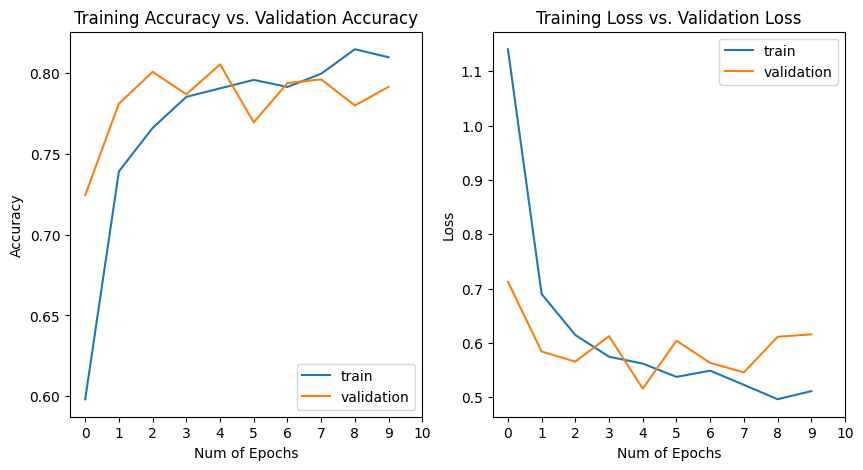

In [ ]:
print("MODEL NAME <---> ",model)
plt.figure(figsize=(10, 5))
  
# summarize history for accuracy
plt.subplot(1, 2 ,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xticks(np.arange(0, epochs+1, epochs/10))
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='best')
  
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xticks(np.arange(0, epochs+1, epochs/10))
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='best')
  
plt.show()

**Performance Metrics**

27/27 [==============================] - 309s 11s/step
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       162
           1       0.93      0.84      0.88       223
           2       0.60      0.89      0.72       155
           3       0.89      0.71      0.79       135
           4       0.75      0.76      0.76       189

    accuracy                           0.79       864
   macro avg       0.81      0.79      0.79       864
weighted avg       0.82      0.79      0.80       864

[[119  10  16   7  10]
 [  9 187  12   4  11]
 [  3   1 138   1  12]
 [  3   2  20  96  14]
 [  1   1  43   0 144]]


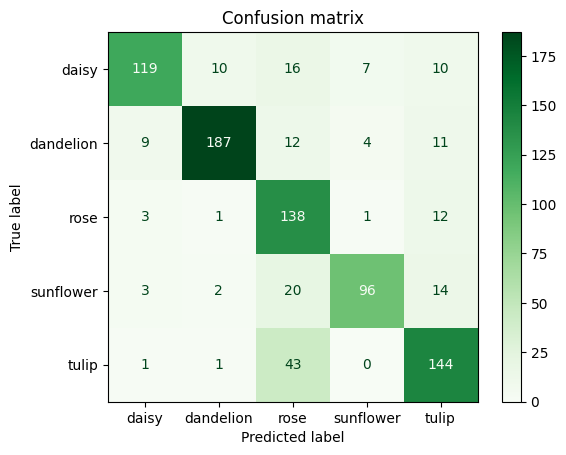

In [ ]:
from sklearn import metrics
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = -1)
predictions = predictions.reshape(1,-1)[0]

labelEncoder.fit_transform(z_test)

print(metrics.classification_report(labelEncoder.fit_transform(z_test), predictions))

print(confusion_matrix(labelEncoder.fit_transform(z_test), predictions))

ConfusionMatrixDisplay.from_predictions(labelEncoder.fit_transform(z_test), predictions, cmap=plt.cm.Greens, display_labels=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])
plt.title('Confusion matrix')
plt.show()